# CaH X-A magnetic field experiment

In [1]:
import sys
sys.path.append("..")

import pickle
import time
import pprint
import numpy as np
from tqdm import tqdm
import multiprocessing
from sympy import Symbol, sin, cos, tan, nsimplify
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
# from optical_bloch.utils.general import flatten
# from optical_bloch import Hamiltonian, Dissipator, BlochEquations
from optical_bloch_test.utils.general import flatten
from optical_bloch_test import Hamiltonian, Dissipator, BlochEquations
from multi_helper_funcs import multi_solve_ode, multi_solve_ode_integrate_excited

## Please note: time should be ns, frequency should be 2Pi GHz

In [2]:
hbar=1.054*1E-34; #[Js]
k_b=1.381*1E-23; #[J/K]
c=299792000; #[m/s]
eps_0=8.854*1E-12; #[F/m]
a0=5.29*1E-11; #[m]
q_e=1.602*1E-19; #[C]
Bohr_mag=1.39962449/1000*2*np.pi; #[GHz/G]

nground = 12
nexcite = 4
ntotal = 16

In [3]:
rabi_matrix = np.zeros([ntotal,ntotal,3])
rabi_matrix[:,:,0] = np.genfromtxt('rabimatrixXA1.csv',delimiter=',')
rabi_matrix[:,:,1] = np.genfromtxt('rabimatrixXA2.csv',delimiter=',')
rabi_matrix[:,:,2] = np.genfromtxt('rabimatrixXA3.csv',delimiter=',')

In [4]:
E0 = Symbol(u'E0', real = True)
Ee = Symbol(u'Ee', real = True)
HFS12 = Symbol(u'HFS12', real = True)
HFS32 = Symbol(u'HFS32', real = True)
SR = Symbol(u'SR', real = True)
HFSB = Symbol(u'HFSB', real = True)

ω1 = Symbol(u'ω1', real = True)
ω2 = Symbol(u'ω2', real = True)
ω3 = Symbol(u'ω3', real = True)
ω4 = Symbol(u'ω4', real = True)
Ω1 = Symbol(u'Ω1', real = True)
Ω2 = Symbol(u'Ω2', real = True)
Ω3 = Symbol(u'Ω3', real = True)
Ω4 = Symbol(u'Ω4', real = True)
Δ1 = Symbol(u'Δ1', real = True)
Δ2 = Symbol(u'Δ2', real = True)
Δ3 = Symbol(u'Δ3', real = True)
Δ4 = Symbol(u'Δ4', real = True)


g_x12F1 = Symbol(u'g_x12F1', real = True)
g_x32F1 = Symbol(u'g_x32F1', real = True)
g_x32F2 = Symbol(u'g_x32F2', real = True)

θ = Symbol(u'θ', real = True)
B = Symbol(u'B', real = True)


In [5]:
# States are added in following order:
# XSigma %1-4 - J=1/2, F=0, m=0;  F=1, m=-1,0,1 ;
# XSigma %5-7 - J=3/2, F=1, m=-1,0,1;
# XSigma %8-12 - J=3/2, F=2, m=-2,-1,0,1,2;
# BSigma %13-16 - J=1/2, F=0, m=0;  F=1, m=-1,0,1

ham = Hamiltonian(ntotal)
ham.addEnergies([E0,E0-HFS12-g_x12F1*B,E0-HFS12,E0-HFS12+g_x12F1*B,
                 E0+SR-g_x32F1*B,E0+SR,E0+SR+g_x32F1*B,
                 E0+SR+HFS32-2*g_x32F2*B,E0+SR+HFS32-g_x32F2*B,E0+SR+HFS32,E0+SR+HFS32+g_x32F2*B,E0+SR+HFS32+2*g_x32F2*B,
                 Ee,Ee+HFSB,Ee+HFSB,Ee+HFSB])

In [6]:
for i in [0]:
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = (-1)/np.sqrt(2)*sin(θ)
            ham.addCoupling(i, j, prefactor*Ω1*rabi_matrix[i,j,0], ω1)
        if rabi_matrix[i, j, 1] != 0:
            prefactor = (1)*cos(θ)
            ham.addCoupling(i, j, prefactor*Ω1*rabi_matrix[i,j,1], ω1)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = (1)/np.sqrt(2)*sin(θ)
            ham.addCoupling(i, j, prefactor*Ω1*rabi_matrix[i,j,2], ω1)
            
for i in [1,2,3]:
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = (-1)/np.sqrt(2)*sin(θ)
            ham.addCoupling(i, j, prefactor*Ω2*rabi_matrix[i,j,0], ω2)
        if rabi_matrix[i, j, 1] != 0:
            prefactor = (1)*cos(θ)
            ham.addCoupling(i, j, prefactor*Ω2*rabi_matrix[i,j,1], ω2)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = (1)/np.sqrt(2)*sin(θ)
            ham.addCoupling(i, j, prefactor*Ω2*rabi_matrix[i,j,2], ω2)
            
for i in [4,5,6]:
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = (-1)/np.sqrt(2)*sin(θ+np.pi/2)
            ham.addCoupling(i, j, prefactor*Ω3*rabi_matrix[i,j,0], ω3)
        if rabi_matrix[i, j, 1] != 0:
            prefactor = (1)*cos(θ+np.pi/2)
            ham.addCoupling(i, j, prefactor*Ω3*rabi_matrix[i,j,1], ω3)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = (1)/np.sqrt(2)*sin(θ+np.pi/2)
            ham.addCoupling(i, j, prefactor*Ω3*rabi_matrix[i,j,2], ω3)
            
for i in [7,8,9,10,11]:
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = (-1)/np.sqrt(2)*sin(θ+np.pi/2)
            ham.addCoupling(i, j, prefactor*Ω4*rabi_matrix[i,j,0], ω4)
        if rabi_matrix[i, j, 1] != 0:
            prefacccccccctor = (1)*cos(θ+np.pi/2)
            ham.addCoupling(i, j, prefactor*Ω4*rabi_matrix[i,j,1], ω4)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = (1)/np.sqrt(2)*sin(θ+np.pi/2)
            ham.addCoupling(i, j, prefactor*Ω4*rabi_matrix[i,j,2], ω4)

In [7]:
ham.eqnTransform()
ham.defineZero(Ee)
ham.defineEnergyDetuning(E0, Ee, Δ1, ω1)
ham.defineEnergyDetuning(E0-HFS12, Ee, Δ2, ω2)
ham.defineEnergyDetuning(E0+SR, Ee, Δ3, ω3)
ham.defineEnergyDetuning(E0+SR+HFS32, Ee, Δ4, ω4)

In [8]:
ham.hamiltonian

Matrix([
[                                           E0,                                             0,                                             0,                                             0,                                                                0,                                                                0,                                                                0,                                                              0,                                                               0,                                                                0,                                                               0,                                                               0,                                                              0,                    -0.166666666666667*Ω1*exp(1.0*I*t*ω1)*sin(θ),                     0.235702260395516*Ω1*exp(1.0*I*t*ω1)*cos(θ),                     0.166666666666667*Ω1*exp(1.0*I*t*ω1)*sin(θ)],
[                  

In [9]:
ham.transformed

Matrix([
[                     -1.0*Δ1,                            0,                            0,                            0,                                               0,                                               0,                                               0,                                             0,                                              0,                                               0,                                              0,                                              0,                                              0,                    -0.166666666666667*Ω1*sin(θ),                     0.235702260395516*Ω1*cos(θ),                     0.166666666666667*Ω1*sin(θ)],
[                           0,          -B*g_x12F1 - 1.0*Δ2,                            0,                            0,                                               0,                                               0,                                               0,                    

In [10]:
transition_strengths=np.zeros([ntotal,ntotal]);
for i in range(ntotal):
    for f in range(ntotal):
        for p in range(3):
            transition_strengths[i,f]=transition_strengths[i,f]+rabi_matrix[i,f,p]**2

In [11]:
BR = np.zeros([ntotal, ntotal])
for i in range(ntotal):
    sums=0
    for f in range(ntotal):
        sums=sums+transition_strengths[i,f]
        
    for f in range(ntotal):
        BR[i,f]=transition_strengths[i,f]/sums
        
for i in range(nground):
    BR[i,:]=0
    

In [12]:
BR[nground:,:]

array([[0.        , 0.22222222, 0.22222222, 0.22222222, 0.11111111,
        0.11111111, 0.11111111, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.22222222, 0.22222222, 0.22222222, 0.        , 0.02777778,
        0.02777778, 0.        , 0.16666667, 0.08333333, 0.02777778,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.22222222, 0.22222222, 0.        , 0.22222222, 0.02777778,
        0.        , 0.02777778, 0.        , 0.08333333, 0.11111111,
        0.08333333, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.22222222, 0.        , 0.22222222, 0.22222222, 0.        ,
        0.02777778, 0.02777778, 0.        , 0.        , 0.02777778,
        0.08333333, 0.16666667, 0.        , 0.        , 0.        ,
        0.        ]])

In [13]:
Γ = Symbol(u'Γ', real = True)
dis = Dissipator(ntotal)

for exct in tqdm(range(nground, ntotal)):
    for grnd in range(nground):
        if BR[exct, grnd] != 0:
            dis.addDecay(exct, grnd, Γ * BR[exct, grnd])

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.94s/it]


In [14]:
dis.dissipator

Matrix([
[Γ*(0.222222222222222*ρ₍₍(t) + 0.222222222222222*ρ₎₎(t) + 0.222222222222222*ρ₏₏(t)),                                                                                  0,                                                                                  0,                                                                                  0,                                                                                    0,                                                                                    0,                                                                                    0,                          0,                                                         0,                                                                                    0,                                                         0,                          0,            -0.5*Γ*ρ₀₌(t),            -0.5*Γ*ρ₀₍(t),            -0.5*Γ*ρ₀₎(t), -0.5*Γ*ρ₀₏(t)],
[                                         

In [15]:
%%time
bloch = BlochEquations(ntotal, dis.density_matrix, ham.transformed, dis.dissipator)

start generateEquations
Wall time: 2.79 s


In [16]:
y0 = np.zeros([ntotal, ntotal], dtype = complex)
for i in range(nground):
    y0[i,i] = 1/nground
y0 = y0.flatten()

In [17]:
Γ_val = 1
Δgroup = -2E-3
Ω1_val = 3*Γ_val
Ω2_val = 3*Γ_val
Ω3_val = 3*Γ_val
Ω4_val = 3*Γ_val
replacements = [(B, 1),
                (HFSB, 3E-3),
                (g_x12F1, -0.33*Bohr_mag),
                (g_x32F1, 0.83*Bohr_mag),
                (g_x32F2, 0.5*Bohr_mag),
                (Δ1, Δgroup),
                (Δ2, Δgroup),
                (Δ3, Δgroup),
                (Δ4, Δgroup),
                (Ω1, Ω1_val),
                (Ω2, Ω2_val),
                (Ω3, Ω3_val),
                (Ω4, Ω4_val),
                (θ, 60/180*np.pi),
                (Γ, Γ_val)]

In [18]:
from julia import Main

nprocs = 12 # number of processes to use for EnsembleDistributed 
Main.eval(f"""
using BenchmarkTools
using Distributed
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using ModelingToolkit
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    using ModelingToolkit
end
""")

    
Main.eval("procs()")

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [19]:
from sympy import MutableDenseMatrix, conjugate, Function, Symbol

t = Symbol('t', real = True)

hamiltonian_symbols = ham.transformed.free_symbols
dissipator_symbols = dis.dissipator.free_symbols
dissipator_symbols = set([d for d in dissipator_symbols if str(d)[0] not in ['ρ', 't']])

for s in list(hamiltonian_symbols) + list(dissipator_symbols):
    Main.eval(f"""
                @everywhere @parameters {str(s)}
                tmp = 0
            """);


lx, ly = ham.transformed.shape
Main.eval(f"""
            @everywhere begin
            H = zeros(Num, {lx}, {ly})
            L = zeros(Num, {lx}, {ly})
            @variables t ρ[1:{lx},1:{ly}](t)
            @parameters icomplex
            D = Differential(t)
            tmp = 0
            end
            """);

# the code below is to transform the symbolic version of Sympy into a form usable with Julia
diss = MutableDenseMatrix(dis.dissipator.copy())

for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(j+1, i+1))
        diss = diss.subs(conjugate(tmp(t)), tmp1(t))
            
for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(i+1, j+1))
        diss = diss.subs(tmp(t), tmp1(t))


# Creating the Hamiltonian matrix and Dissipator matrix in Julia
for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval = str(ham.transformed[idx-1,idy-1])
        dval = str(diss[idx-1, idy-1])
        dval = dval.replace('(t)', '')
        Main.eval(f"""
                @everywhere begin
                H[{idx},{idy}] = {hval}
                L[{idx},{idy}] = {dval}
                tmp = 0
                end
                """);
        
# ham_pars = ham.transformed.free_symbols

In [20]:
# Creating the system of equations
ham_string = ','.join([str(h) for h in hamiltonian_symbols])
diss_string = ','.join([str(d) for d in dissipator_symbols])

Main.eval(f"""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:{lx} for idy in 1:{ly}];
    bloch = ODESystem(eqns)
    tmp = 0
end
""");

In [21]:
# initial populations
y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
for _ in range(ntotal):
    y0[_,_] = 1/ntotal
Main.ρ_ini = y0
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [22]:
print(hamiltonian_symbols,dissipator_symbols)

{B, Δ3, Ω4, θ, Δ1, g_x12F1, Ω2, Ω3, Δ2, g_x32F1, HFSB, Ω1, g_x32F2, Δ4} {Γ}


In [23]:
Main.eval("""
    @everywhere begin
    Γ_val = 1/33
    Bohr_mag=1.39962449/1000*2*pi
    Δgroup = 0E-3
    Ω1_val = 3*Γ_val
    Ω2_val = 3*Γ_val
    Ω3_val = 3*Γ_val
    Ω4_val = 3*Γ_val
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

In [24]:
# setting up the parameters of the model and initial conditions
Main.eval("""
    @everywhere begin
    p = [
    θ => 30*pi/180,
    B => 3,
    Δ1 => Δgroup,
    Δ2 => Δgroup,
    Δ3 => Δgroup,
    Δ4 => Δgroup,
    Ω1 => Ω1_val,
    Ω2 => Ω2_val,
    Ω3 => Ω3_val,
    Ω4 => Ω4_val,
    g_x12F1 => -0.33*Bohr_mag,
    g_x32F1 => 0.83*Bohr_mag,
    g_x32F2 => 0.5*Bohr_mag,
    Γ => Γ_val,
    HFSB => 2E-3,
    icomplex => im
    ]
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

In [25]:
# creating the problem to solve
Main.eval("""
@everywhere begin
    tspan = (0.0, 15000.)
    prob = ODEProblem(bloch, ρ_ini, tspan, p, jac = true)
end
""");

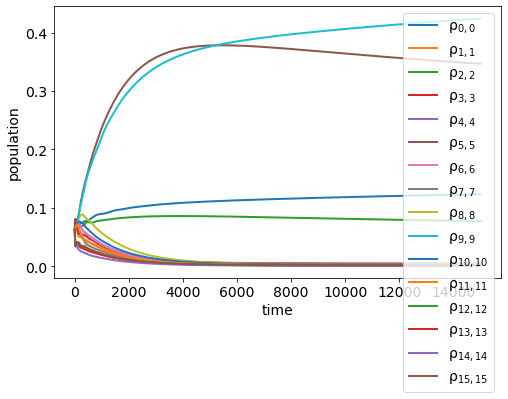

In [26]:
# solving the ODEProblem, keep in mind that the first run compiles called functions
# the first run will be significantly slower (due to compilation), but any subsequent solves are fast
Main.eval("@time sol = solve(prob, Tsit5(), abstol = 1e-10, reltol = 1e-10)");
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t") 
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

## sweep B field and theta

In [27]:
# creating the parameter space to scan
var1list = np.linspace(0,np.pi/2,30)
var2list = np.linspace(0,10,30)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [28]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    Δgroup = 0
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i,1],
        B => params[i,2],
        Δ1 => Δgroup,
        Δ2 => Δgroup,
        Δ3 => Δgroup,
        Δ4 => Δgroup,
        Ω1 => Ω1_val,
        Ω2 => Ω2_val,
        Ω3 => Ω3_val,
        Ω4 => Ω4_val,
        g_x12F1 => -0.33*Bohr_mag,
        g_x32F1 => 0.83*Bohr_mag,
        g_x32F2 => 0.5*Bohr_mag,
        Γ => Γ_val,
        HFSB => 2E-3,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [29]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(13-1)*17])+real(sol.u[j][1+(14-1)*17])+real(sol.u[j][1+(15-1)*17])+real(sol.u[j][1+(16-1)*17]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [30]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

116.2917991

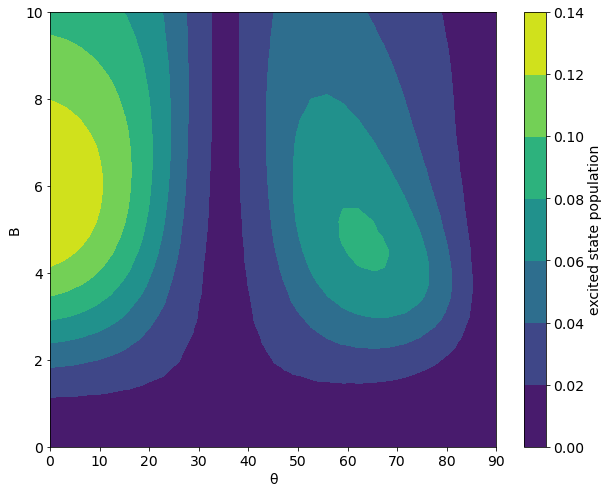

In [31]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/15000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## use power to calculate rabi rate

In [32]:
# creating the parameter space to scan
var1list = np.linspace(0,np.pi/2,30)
var2list = np.linspace(0,20,60)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [33]:
# Calculate rabi rate using Powers
Main.eval("""
    @everywhere begin
    
    Δgroup = 0
    lambda_laser = 695E-9
    c=299792000
    hbar=1.054E-34
    Isat = 2*pi*hbar*c*Γ_val*1E9*pi/(3*lambda_laser^3)

    Power_laser1 = 0.5*30E-3/1
    Power_laser2 = 0.5*30E-3/3
    Power_laser3 = 0.5*40E-3/3
    Power_laser4 = 0.5*40E-3/5

    beam_dia = 3.17E-3
    Int_laser1 = Power_laser1*4/pi/beam_dia^2
    Int_laser2 = Power_laser2*4/pi/beam_dia^2
    Int_laser3 = Power_laser3*4/pi/beam_dia^2
    Int_laser4 = Power_laser4*4/pi/beam_dia^2
    
    Ω1_val = sqrt(Int_laser1/Isat/2)*Γ_val
    Ω2_val = sqrt(Int_laser2/Isat/2)*Γ_val
    Ω3_val = sqrt(Int_laser3/Isat/2)*Γ_val
    Ω4_val = sqrt(Int_laser4/Isat/2)*Γ_val
    tmp =0;
end
""");
print(Main.Γ_val,Main.Ω1_val,Main.Ω2_val,Main.Ω3_val,Main.Ω4_val)

0.030303030303030304 0.21563144708109658 0.12449487401801966 0.1437542980540644 0.11135160046182574


In [34]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i,1],
        B => params[i,2],
        Δ1 => Δgroup,
        Δ2 => Δgroup,
        Δ3 => Δgroup,
        Δ4 => Δgroup,
        Ω1 => Ω1_val,
        Ω2 => Ω2_val,
        Ω3 => Ω3_val,
        Ω4 => Ω4_val,
        g_x12F1 => -0.33*Bohr_mag,
        g_x32F1 => 0.83*Bohr_mag,
        g_x32F2 => 0.5*Bohr_mag,
        Γ => Γ_val,
        HFSB => 2E-3,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [35]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(13-1)*17])+real(sol.u[j][1+(14-1)*17])+real(sol.u[j][1+(15-1)*17])+real(sol.u[j][1+(16-1)*17]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [36]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

277.0062888

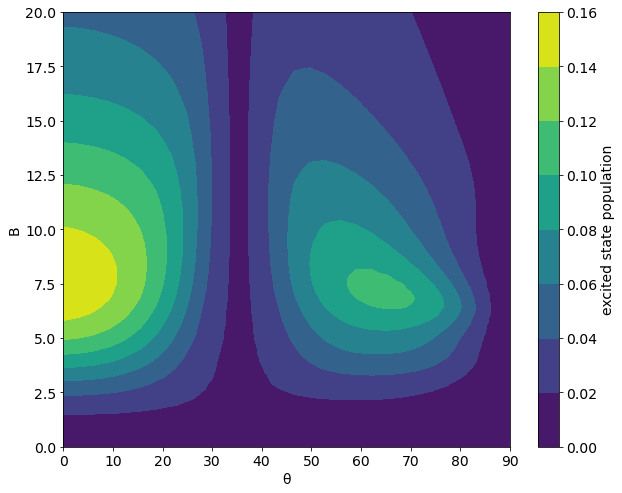

In [37]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/15000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## vary rabi rate to adjust distribution 1
reduce all rabi rate by 10

In [38]:
# creating the parameter space to scan
var1list = np.linspace(0,np.pi/2,30)
var2list = np.linspace(0,20,60)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [39]:
# Calculate rabi rate using Powers
Main.eval("""
    @everywhere begin
    
    Δgroup = 0
    lambda_laser = 695E-9
    c=299792000
    hbar=1.054E-34
    Isat = 2*pi*hbar*c*Γ_val*1E9*pi/(3*lambda_laser^3)

    Power_laser1 = 0.1*0.5*30E-3/1
    Power_laser2 = 0.1*0.5*30E-3/3
    Power_laser3 = 0.1*0.5*40E-3/3
    Power_laser4 = 0.1*0.5*40E-3/5

    beam_dia = 3.17E-3
    Int_laser1 = Power_laser1*4/pi/beam_dia^2
    Int_laser2 = Power_laser2*4/pi/beam_dia^2
    Int_laser3 = Power_laser3*4/pi/beam_dia^2
    Int_laser4 = Power_laser4*4/pi/beam_dia^2
    
    Ω1_val = sqrt(Int_laser1/Isat/2)*Γ_val
    Ω2_val = sqrt(Int_laser2/Isat/2)*Γ_val
    Ω3_val = sqrt(Int_laser3/Isat/2)*Γ_val
    Ω4_val = sqrt(Int_laser4/Isat/2)*Γ_val
    tmp =0;
end
""");
print(Main.Γ_val,Main.Ω1_val,Main.Ω2_val,Main.Ω3_val,Main.Ω4_val)

0.030303030303030304 0.06818865079343318 0.03936873589126604 0.04545910052895545 0.03521246785644264


In [40]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i,1],
        B => params[i,2],
        Δ1 => Δgroup,
        Δ2 => Δgroup,
        Δ3 => Δgroup,
        Δ4 => Δgroup,
        Ω1 => Ω1_val,
        Ω2 => Ω2_val,
        Ω3 => Ω3_val,
        Ω4 => Ω4_val,
        g_x12F1 => -0.33*Bohr_mag,
        g_x32F1 => 0.83*Bohr_mag,
        g_x32F2 => 0.5*Bohr_mag,
        Γ => Γ_val,
        HFSB => 2E-3,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [41]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(13-1)*17])+real(sol.u[j][1+(14-1)*17])+real(sol.u[j][1+(15-1)*17])+real(sol.u[j][1+(16-1)*17]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [42]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

273.6038121

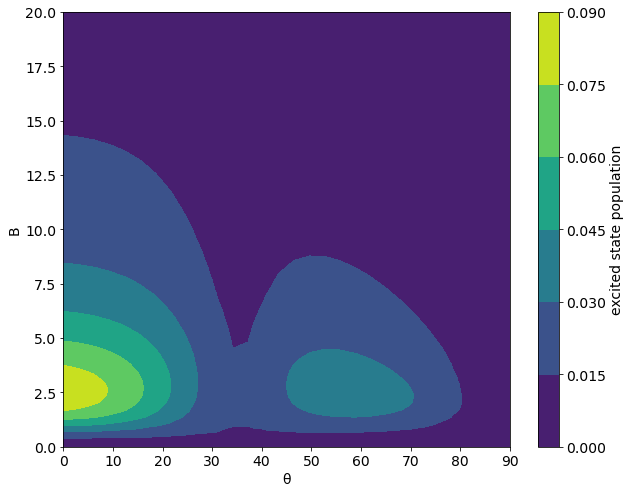

In [43]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/15000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## vary rabi rate to adjust distribution 2
increase all rabi rate by 10

In [44]:
# creating the parameter space to scan
var1list = np.linspace(0,np.pi/2,60)
var2list = np.linspace(0,60,60)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [45]:
# Calculate rabi rate using Powers
Main.eval("""
    @everywhere begin
    
    Δgroup = 0

    lambda_laser = 695E-9
    c=299792000
    hbar=1.054E-34
    Isat = 2*pi*hbar*c*Γ_val*1E9*pi/(3*lambda_laser^3)

    Power_laser1 = 10*0.5*30E-3/1
    Power_laser2 = 10*0.5*30E-3/3
    Power_laser3 = 10*0.5*40E-3/3
    Power_laser4 = 10*0.5*40E-3/5

    beam_dia = 3.17E-3
    Int_laser1 = Power_laser1*4/pi/beam_dia^2
    Int_laser2 = Power_laser2*4/pi/beam_dia^2
    Int_laser3 = Power_laser3*4/pi/beam_dia^2
    Int_laser4 = Power_laser4*4/pi/beam_dia^2
    
    Ω1_val = sqrt(Int_laser1/Isat/2)*Γ_val
    Ω2_val = sqrt(Int_laser2/Isat/2)*Γ_val
    Ω3_val = sqrt(Int_laser3/Isat/2)*Γ_val
    Ω4_val = sqrt(Int_laser4/Isat/2)*Γ_val
    tmp =0;
end
""");
print(Main.Γ_val,Main.Ω1_val,Main.Ω2_val,Main.Ω3_val,Main.Ω4_val)

0.030303030303030304 0.6818865079343319 0.3936873589126604 0.45459100528955454 0.35212467856442653


In [46]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i,1],
        B => params[i,2],
        Δ1 => Δgroup,
        Δ2 => Δgroup,
        Δ3 => Δgroup,
        Δ4 => Δgroup,
        Ω1 => Ω1_val,
        Ω2 => Ω2_val,
        Ω3 => Ω3_val,
        Ω4 => Ω4_val,
        g_x12F1 => -0.33*Bohr_mag,
        g_x32F1 => 0.83*Bohr_mag,
        g_x32F2 => 0.5*Bohr_mag,
        Γ => Γ_val,
        HFSB => 2E-3,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [47]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(13-1)*17])+real(sol.u[j][1+(14-1)*17])+real(sol.u[j][1+(15-1)*17])+real(sol.u[j][1+(16-1)*17]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [48]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

1377.6184771

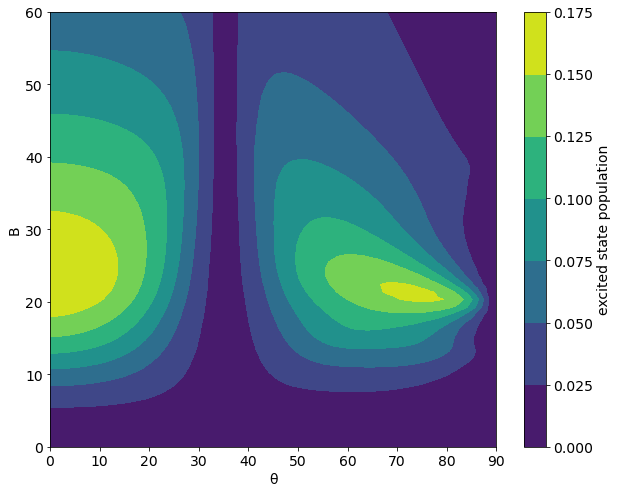

In [49]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/15000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## vary rabi rate to adjust distribution 3 
reduce J=3/2 leg rabi rate by 10

In [50]:
# creating the parameter space to scan
var1list = np.linspace(0,np.pi/2,30)
var2list = np.linspace(0,20,60)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [51]:
# Calculate rabi rate using Powers
Main.eval("""
    @everywhere begin
    
    Δgroup = 0

    lambda_laser = 695E-9
    c=299792000
    hbar=1.054E-34
    Isat = 2*pi*hbar*c*Γ_val*1E9*pi/(3*lambda_laser^3)

    Power_laser1 = 0.5*30E-3/1
    Power_laser2 = 0.5*30E-3/3
    Power_laser3 = 0.1*0.5*40E-3/3
    Power_laser4 = 0.1*0.5*40E-3/5

    beam_dia = 3.17E-3
    Int_laser1 = Power_laser1*4/pi/beam_dia^2
    Int_laser2 = Power_laser2*4/pi/beam_dia^2
    Int_laser3 = Power_laser3*4/pi/beam_dia^2
    Int_laser4 = Power_laser4*4/pi/beam_dia^2
    
    Ω1_val = sqrt(Int_laser1/Isat/2)*Γ_val
    Ω2_val = sqrt(Int_laser2/Isat/2)*Γ_val
    Ω3_val = sqrt(Int_laser3/Isat/2)*Γ_val
    Ω4_val = sqrt(Int_laser4/Isat/2)*Γ_val
    tmp =0;
end
""");
print(Main.Γ_val,Main.Ω1_val,Main.Ω2_val,Main.Ω3_val,Main.Ω4_val)

0.030303030303030304 0.21563144708109658 0.12449487401801966 0.04545910052895545 0.03521246785644264


In [52]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i,1],
        B => params[i,2],
        Δ1 => Δgroup,
        Δ2 => Δgroup,
        Δ3 => Δgroup,
        Δ4 => Δgroup,
        Ω1 => Ω1_val,
        Ω2 => Ω2_val,
        Ω3 => Ω3_val,
        Ω4 => Ω4_val,
        g_x12F1 => -0.33*Bohr_mag,
        g_x32F1 => 0.83*Bohr_mag,
        g_x32F2 => 0.5*Bohr_mag,
        Γ => Γ_val,
        HFSB => 2E-3,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [53]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(13-1)*17])+real(sol.u[j][1+(14-1)*17])+real(sol.u[j][1+(15-1)*17])+real(sol.u[j][1+(16-1)*17]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [54]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

292.8689827

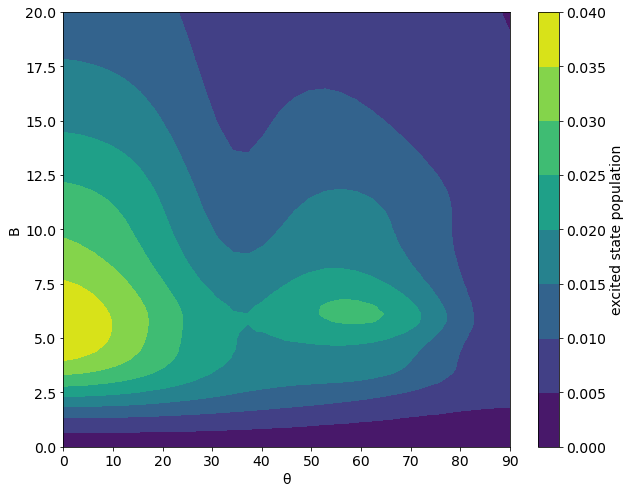

In [55]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/15000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## vary rabi rate to adjust distribution 4
reduce J=1/2 rabi rate by 10

In [56]:
# creating the parameter space to scan
var1list = np.linspace(0,np.pi/2,30)
var2list = np.linspace(0,20,60)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [57]:
# Calculate rabi rate using Powers
Main.eval("""
    @everywhere begin
    
    Δgroup = 0

    lambda_laser = 695E-9
    c=299792000
    hbar=1.054E-34
    Isat = 2*pi*hbar*c*Γ_val*1E9*pi/(3*lambda_laser^3)

    Power_laser1 = 0.1*0.5*30E-3/1
    Power_laser2 = 0.1*0.5*30E-3/3
    Power_laser3 = 0.5*40E-3/3
    Power_laser4 = 0.5*40E-3/5

    beam_dia = 3.17E-3
    Int_laser1 = Power_laser1*4/pi/beam_dia^2
    Int_laser2 = Power_laser2*4/pi/beam_dia^2
    Int_laser3 = Power_laser3*4/pi/beam_dia^2
    Int_laser4 = Power_laser4*4/pi/beam_dia^2
    
    Ω1_val = sqrt(Int_laser1/Isat/2)*Γ_val
    Ω2_val = sqrt(Int_laser2/Isat/2)*Γ_val
    Ω3_val = sqrt(Int_laser3/Isat/2)*Γ_val
    Ω4_val = sqrt(Int_laser4/Isat/2)*Γ_val
    tmp =0;
end
""");
print(Main.Γ_val,Main.Ω1_val,Main.Ω2_val,Main.Ω3_val,Main.Ω4_val)

0.030303030303030304 0.06818865079343318 0.03936873589126604 0.1437542980540644 0.11135160046182574


In [58]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i,1],
        B => params[i,2],
        Δ1 => Δgroup,
        Δ2 => Δgroup,
        Δ3 => Δgroup,
        Δ4 => Δgroup,
        Ω1 => Ω1_val,
        Ω2 => Ω2_val,
        Ω3 => Ω3_val,
        Ω4 => Ω4_val,
        g_x12F1 => -0.33*Bohr_mag,
        g_x32F1 => 0.83*Bohr_mag,
        g_x32F2 => 0.5*Bohr_mag,
        Γ => Γ_val,
        HFSB => 2E-3,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [59]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(13-1)*17])+real(sol.u[j][1+(14-1)*17])+real(sol.u[j][1+(15-1)*17])+real(sol.u[j][1+(16-1)*17]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [60]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

252.3072001

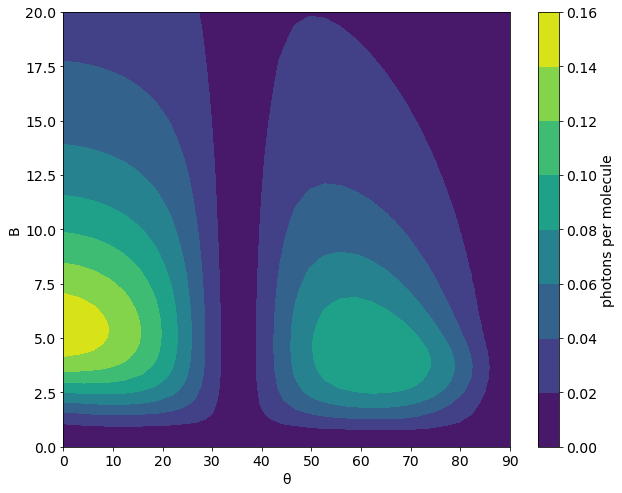

In [61]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/15000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('photons per molecule')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## check if detuning has any correlation with other parameters: B field strength

In [74]:
# creating the parameter space to scan
var1list = np.linspace(-100E-3, 100E-3, 40)
var2list = np.linspace(0,20,40)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [75]:
# Calculate rabi rate using Powers
Main.eval("""
    @everywhere begin
    lambda_laser = 695E-9
    c=299792000
    hbar=1.054E-34
    Isat = 2*pi*hbar*c*Γ_val*1E9*pi/(3*lambda_laser^3)

    Power_laser1 = 0.5*30E-3/1
    Power_laser2 = 0.5*30E-3/3
    Power_laser3 = 0.5*40E-3/3
    Power_laser4 = 0.5*40E-3/5

    beam_dia = 3.17E-3
    Int_laser1 = Power_laser1*4/pi/beam_dia^2
    Int_laser2 = Power_laser2*4/pi/beam_dia^2
    Int_laser3 = Power_laser3*4/pi/beam_dia^2
    Int_laser4 = Power_laser4*4/pi/beam_dia^2
    
    Ω1_val = sqrt(Int_laser1/Isat/2)*Γ_val
    Ω2_val = sqrt(Int_laser2/Isat/2)*Γ_val
    Ω3_val = sqrt(Int_laser3/Isat/2)*Γ_val
    Ω4_val = sqrt(Int_laser4/Isat/2)*Γ_val
    tmp =0;
end
""");
print(Main.Γ_val,Main.Ω1_val,Main.Ω2_val,Main.Ω3_val,Main.Ω4_val)

0.030303030303030304 0.21563144708109658 0.12449487401801966 0.1437542980540644 0.11135160046182574


In [76]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    Δ_group = params[i,1]
    pnew = ModelingToolkit.varmap_to_vars([
        θ => 60*pi/180,
        B => params[i,2],
        Δ1 => Δ_group,
        Δ2 => Δ_group,
        Δ3 => Δ_group,
        Δ4 => Δ_group,
        Ω1 => Ω1_val,
        Ω2 => Ω2_val,
        Ω3 => Ω3_val,
        Ω4 => Ω4_val,
        g_x12F1 => -0.33*Bohr_mag,
        g_x32F1 => 0.83*Bohr_mag,
        g_x32F2 => 0.5*Bohr_mag,
        Γ => Γ_val,
        HFSB => 2E-3,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [77]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(13-1)*17])+real(sol.u[j][1+(14-1)*17])+real(sol.u[j][1+(15-1)*17])+real(sol.u[j][1+(16-1)*17]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [78]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

253.8770776

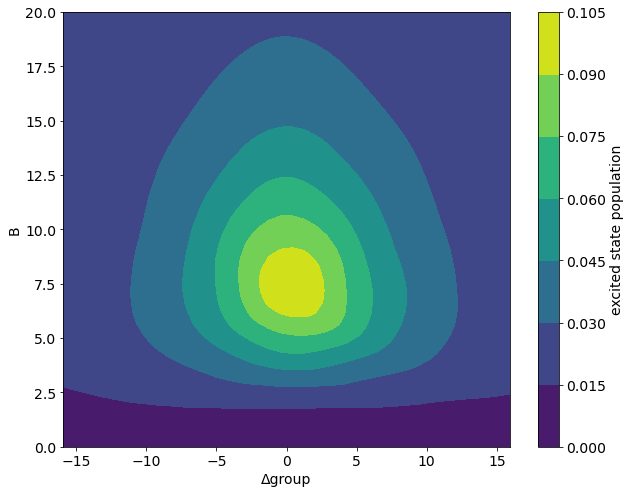

In [79]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*1E3/(2*np.pi), params[:,1], np.array(Main.eval("sim.u"))/15000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('Δgroup')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## check if detuning has any correlation with other parameters: angle

In [80]:
# creating the parameter space to scan
var1list = np.linspace(-100E-3, 100E-3, 60)
var2list = np.linspace(0, np.pi/2, 30)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [81]:
# Calculate rabi rate using Powers
Main.eval("""
    @everywhere begin
    lambda_laser = 695E-9
    c=299792000
    hbar=1.054E-34
    Isat = 2*pi*hbar*c*Γ_val*1E9*pi/(3*lambda_laser^3)

    Power_laser1 = 0.5*30E-3/1
    Power_laser2 = 0.5*30E-3/3
    Power_laser3 = 0.5*40E-3/3
    Power_laser4 = 0.5*40E-3/5

    beam_dia = 3.17E-3
    Int_laser1 = Power_laser1*4/pi/beam_dia^2
    Int_laser2 = Power_laser2*4/pi/beam_dia^2
    Int_laser3 = Power_laser3*4/pi/beam_dia^2
    Int_laser4 = Power_laser4*4/pi/beam_dia^2
    
    Ω1_val = sqrt(Int_laser1/Isat/2)*Γ_val
    Ω2_val = sqrt(Int_laser2/Isat/2)*Γ_val
    Ω3_val = sqrt(Int_laser3/Isat/2)*Γ_val
    Ω4_val = sqrt(Int_laser4/Isat/2)*Γ_val
    tmp =0;
end
""");
print(Main.Γ_val,Main.Ω1_val,Main.Ω2_val,Main.Ω3_val,Main.Ω4_val)

0.030303030303030304 0.21563144708109658 0.12449487401801966 0.1437542980540644 0.11135160046182574


In [82]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    Δ_group = params[i,1]
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i,2],
        B => 7.5,
        Δ1 => Δ_group,
        Δ2 => Δ_group,
        Δ3 => Δ_group,
        Δ4 => Δ_group,
        Ω1 => Ω1_val,
        Ω2 => Ω2_val,
        Ω3 => Ω3_val,
        Ω4 => Ω4_val,
        g_x12F1 => -0.33*Bohr_mag,
        g_x32F1 => 0.83*Bohr_mag,
        g_x32F2 => 0.5*Bohr_mag,
        Γ => Γ_val,
        HFSB => 2E-3,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [83]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(13-1)*17])+real(sol.u[j][1+(14-1)*17])+real(sol.u[j][1+(15-1)*17])+real(sol.u[j][1+(16-1)*17]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [84]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

206.9557946

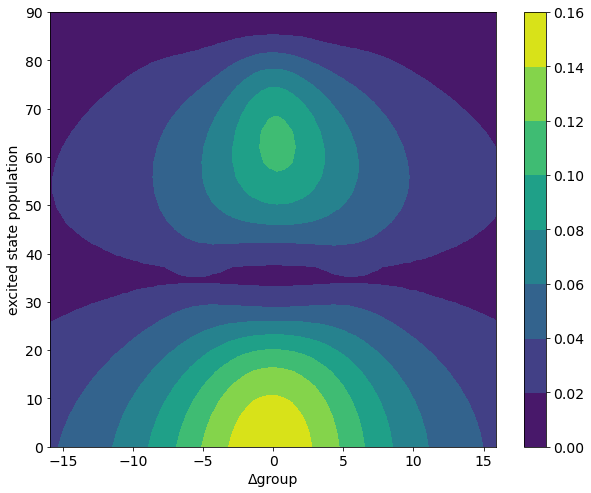

In [85]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*1E3/(2*np.pi), params[:,1]*180/np.pi, np.array(Main.eval("sim.u"))/15000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('Δgroup')
ax.set_ylabel('θ')
ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## investigate what can give this abnormal pattern: HFSB

In [86]:
# creating the parameter space to scan
var1list = np.linspace(0,np.pi/2,30)
var2list = np.linspace(0,20,30)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [87]:
# Calculate rabi rate using Powers
Main.eval("""
    @everywhere begin
    
    Δgroup = 0
    lambda_laser = 695E-9
    c=299792000
    hbar=1.054E-34
    Isat = 2*pi*hbar*c*Γ_val*1E9*pi/(3*lambda_laser^3)

    Power_laser1 = 0.5*30E-3/1
    Power_laser2 = 0.5*30E-3/3
    Power_laser3 = 0.5*40E-3/3
    Power_laser4 = 0.5*40E-3/5

    beam_dia = 3.17E-3
    Int_laser1 = Power_laser1*4/pi/beam_dia^2
    Int_laser2 = Power_laser2*4/pi/beam_dia^2
    Int_laser3 = Power_laser3*4/pi/beam_dia^2
    Int_laser4 = Power_laser4*4/pi/beam_dia^2
    
    Ω1_val = sqrt(Int_laser1/Isat/2)*Γ_val
    Ω2_val = sqrt(Int_laser2/Isat/2)*Γ_val
    Ω3_val = sqrt(Int_laser3/Isat/2)*Γ_val
    Ω4_val = sqrt(Int_laser4/Isat/2)*Γ_val
    tmp =0;
end
""");
print(Main.Γ_val,Main.Ω1_val,Main.Ω2_val,Main.Ω3_val,Main.Ω4_val)

0.030303030303030304 0.21563144708109658 0.12449487401801966 0.1437542980540644 0.11135160046182574


In [88]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i,1],
        B => params[i,2],
        Δ1 => Δgroup,
        Δ2 => Δgroup,
        Δ3 => Δgroup,
        Δ4 => Δgroup,
        Ω1 => Ω1_val,
        Ω2 => Ω2_val,
        Ω3 => Ω3_val,
        Ω4 => Ω4_val,
        g_x12F1 => -0.33*Bohr_mag,
        g_x32F1 => 0.83*Bohr_mag,
        g_x32F2 => 0.5*Bohr_mag,
        Γ => Γ_val,
        HFSB => 10E-3,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [89]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(13-1)*17])+real(sol.u[j][1+(14-1)*17])+real(sol.u[j][1+(15-1)*17])+real(sol.u[j][1+(16-1)*17]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [90]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

145.6576658

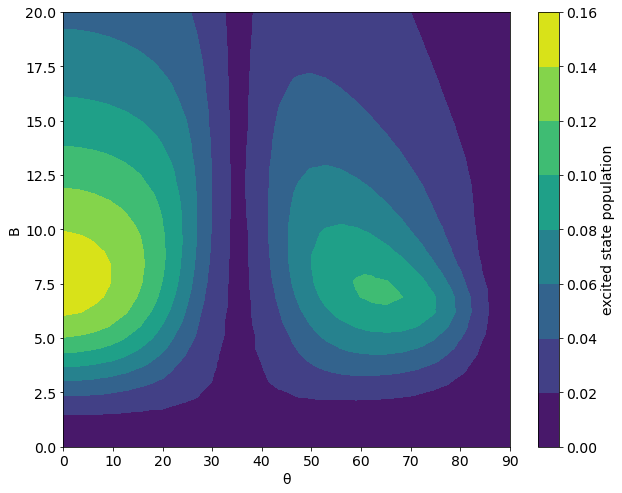

In [91]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/15000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## investigate what can give this abnormal pattern: HFSB

In [92]:
# creating the parameter space to scan
var1list = np.linspace(0,np.pi/2,30)
var2list = np.linspace(0,20,30)
params = np.array(np.meshgrid(var1list, var2list)).T.reshape(-1,2)

Main.params = params
Main.eval("@everywhere params = $params")

In [93]:
# Calculate rabi rate using Powers
Main.eval("""
    @everywhere begin
    
    Δgroup = 0
    lambda_laser = 695E-9
    c=299792000
    hbar=1.054E-34
    Isat = 2*pi*hbar*c*Γ_val*1E9*pi/(3*lambda_laser^3)

    Power_laser1 = 0.5*30E-3/1
    Power_laser2 = 0.5*30E-3/3
    Power_laser3 = 0.5*40E-3/3
    Power_laser4 = 0.5*40E-3/5

    beam_dia = 3.17E-3
    Int_laser1 = Power_laser1*4/pi/beam_dia^2
    Int_laser2 = Power_laser2*4/pi/beam_dia^2
    Int_laser3 = Power_laser3*4/pi/beam_dia^2
    Int_laser4 = Power_laser4*4/pi/beam_dia^2
    
    Ω1_val = sqrt(Int_laser1/Isat/2)*Γ_val
    Ω2_val = sqrt(Int_laser2/Isat/2)*Γ_val
    Ω3_val = sqrt(Int_laser3/Isat/2)*Γ_val
    Ω4_val = sqrt(Int_laser4/Isat/2)*Γ_val
    tmp =0;
end
""");
print(Main.Γ_val,Main.Ω1_val,Main.Ω2_val,Main.Ω3_val,Main.Ω4_val)

0.030303030303030304 0.21563144708109658 0.12449487401801966 0.1437542980540644 0.11135160046182574


In [94]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        θ => params[i,1],
        B => params[i,2],
        Δ1 => Δgroup,
        Δ2 => Δgroup,
        Δ3 => Δgroup,
        Δ4 => Δgroup,
        Ω1 => Ω1_val,
        Ω2 => Ω2_val,
        Ω3 => Ω3_val,
        Ω4 => Ω4_val,
        g_x12F1 => -0.33*Bohr_mag,
        g_x32F1 => 0.83*Bohr_mag,
        g_x32F2 => 0.5*Bohr_mag,
        Γ => Γ_val,
        HFSB => 0E-3,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [95]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][1+(13-1)*17])+real(sol.u[j][1+(14-1)*17])+real(sol.u[j][1+(15-1)*17])+real(sol.u[j][1+(16-1)*17]) for j in 1:size(sol.u)[1]]), false
       end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [96]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

142.6563415

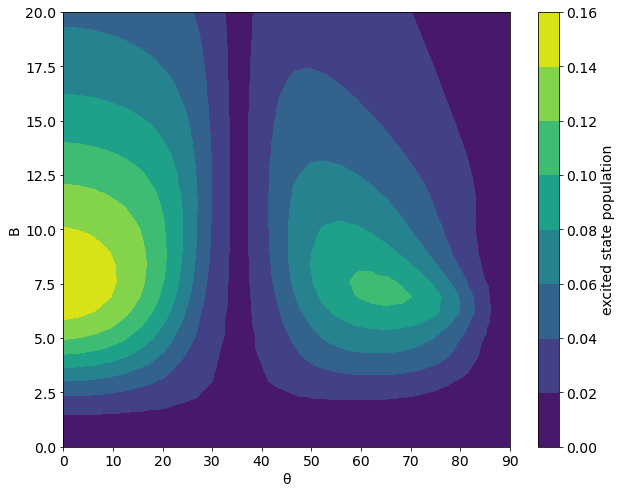

In [97]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]*180/np.pi, params[:,1], np.array(Main.eval("sim.u"))/15000)

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('excited state population')
# ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## Sample Plot

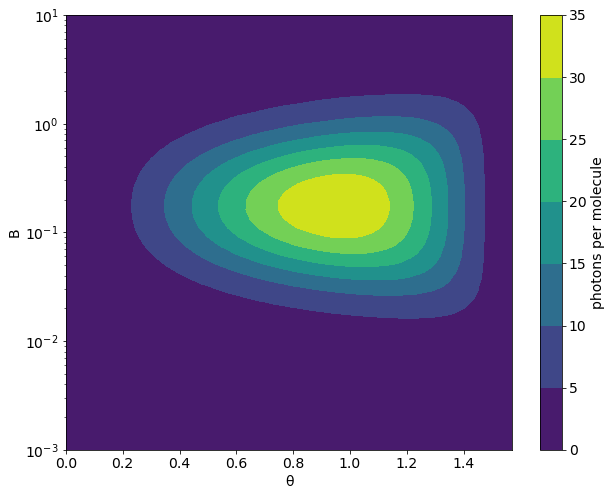

In [49]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u")))

cbar = fig.colorbar(tcf)

ax.set_xlabel('θ')
ax.set_ylabel('B')
cbar.ax.set_ylabel('photons per molecule')
ax.set_yscale('log')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

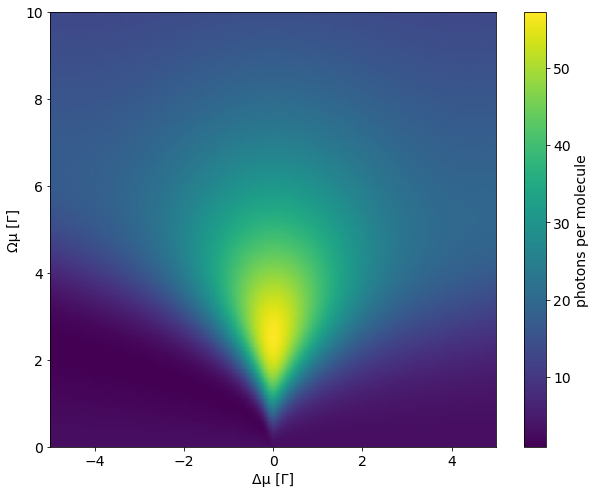

In [56]:
X, Y = np.meshgrid(np.unique(params[:,0]), np.unique(params[:,1]))

fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X, Y, np.array(Main.eval("sim.u")).reshape(-1,X.shape[1]).T, shading="gouraud")
cbar = fig.colorbar(c)

ax.set_xlabel('Δμ [Γ]')
ax.set_ylabel('Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

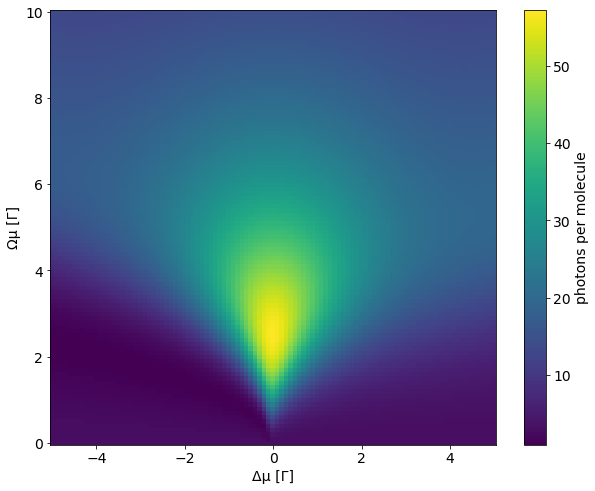

In [57]:
X, Y = np.meshgrid(np.unique(params[:,0]), np.unique(params[:,1]))

fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X, Y, np.array(Main.eval("sim.u")).reshape(-1,X.shape[1]).T, shading="auto")
cbar = fig.colorbar(c)

ax.set_xlabel('Δμ [Γ]')
ax.set_ylabel('Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)